In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import sys
import os
import os.path as path
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
parameters = {
    'figure.figsize': (7,5),
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    'mathtext.default': 'it',
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
plt.rcParams.update(parameters)

# original library
import tbmodels as tb
from kpmpy import KPM

# DOS (Kernel Polynomial Method)

エネルギーの関数 $f$ はチェビシェフ多項式で展開できる。

$$
f(\tilde{E}) = \frac{1}{\pi\sqrt{1-\tilde{E}^2}}\left[\mu_0 + 2\sum_{n=1}^\infty\mu_nT_n(\tilde{E})\right]\tag{1}
$$

ここで $T_n$ はチェビシェフ多項式

$$
\begin{align}
    T_0(x) &= 1,\ \ \ T_1(x) = x,\\[1mm]
    T_{n+1}(x) &= 2xT_n(x) - T_{n-1}(x)\tag{2}
\end{align}
$$

であり、$\mu_n$ は与えられた演算子 $A$ を用いて

$$
\mu_n = \mathrm{Tr}\left[AT_n(\tilde{H})\right]\tag{3}
$$

で求められる。DOS 計算に演算子を与えない。 $A=1$  
チェビシェフ多項式は $[-1,1]$ の範囲で定義されるため、適切なスケーリングが必要。$\tilde{H}$、$\tilde{E}$ はそれぞれスケーリングされたハミルトニアン、エネルギーで、元のハミルトニアン $H$、エネルギー $E$ とは

$$
\begin{align}
    \tilde{H} &= \frac{H-b}{a}\\[2mm]
    \tilde{E} &= \frac{E-b}{a}\tag{4}
\end{align}
$$

の関係がある。

実際には展開の項数は有限 $(N)$ であり、高周波成分のカットオフが起きる。滑らかなスペクトルを得るために、減衰カーネル $g_n$ を導入する。$\mu_n\rightarrow g_n\mu_n$  
減衰カーネル $g_n$ には、何もしない Dirichlet カーネル

$$
g_n = 1\tag{5}
$$

や、最も一般的に使用される Jackson カーネル

$$
g_n = \frac{1}{N+1}\left[(N-n+1)\cos\frac{\pi n}{N+1} + \sin\frac{\pi n}{N+1}\cot\frac{\pi}{N+1}\right]\tag{6}
$$

がある。他に、グリーン関数の計算に使用される Lorentz カーネルも実装している。

実際には、(3) のトレースは乱数を使用して近似的に計算する。
重み $\mu_n$ はランダムベクトル $|\alpha\rangle$ を用いて以下のように計算される。

$$
\begin{align}
    &|\alpha_0\rangle = |\alpha\rangle\\[1mm]
    &|\alpha_1\rangle = \tilde{H}|\alpha_0\rangle\\[1mm]
    &|\alpha_{n+1}\rangle = 2\tilde{H}|\alpha_n\rangle - |\alpha_{n-1}\rangle\tag{7}
\end{align}
$$

$$
\mu_n = \langle\alpha|A|\alpha_n\rangle\tag{8}
$$

$A=1$ のときは次の関係を用いると計算が半分で済む。

$$
\begin{align}
    \mu_{2n} &= 2\langle\alpha_n|\alpha_n\rangle - \mu_0\\[1mm]
    \mu_{2n+1} &= 2\langle\alpha_{n+1}|\alpha_n\rangle - \mu_1\tag{9}
\end{align}
$$

ランダムベクトルの確率分布には、ガウス分布が用いられる。

## Tight-binding model

ハミルトニアン

$$
H = t\sum_{\langle i,j\rangle} c^{\dag}_j c^{}_i + \sum_i W_i c^{\dag}_i c^{}_i
$$

tbmodels.py ではデフォルトで $t=-1$ としている。例えば、x方向のホッピングと y方向のホッピングを変えたい場合はカスタマイズが必要。  
また、tbmodels.py は正方格子のみサポート。

### 2D

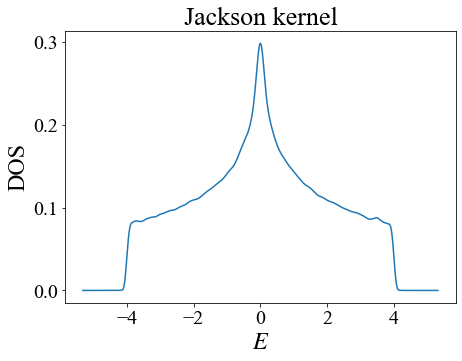

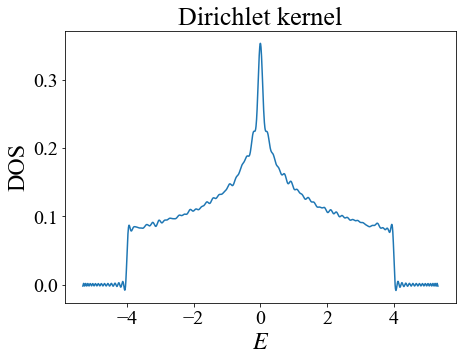

In [2]:
shape = (200,200)
H = tb.get_tight_binding_Hamiltonian(shape)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
dE = energy[1] - energy[0]
dos = kpm.get_DOS(energy)
dos /= np.sum(dos*dE)
plt.plot(energy, dos)
plt.title('Jackson kernel')
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Dirichlet', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
dE = energy[1] - energy[0]
dos = kpm.get_DOS(energy)
dos /= np.sum(dos*dE)
plt.plot(energy, dos)
plt.title('Dirichlet kernel')
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 1D

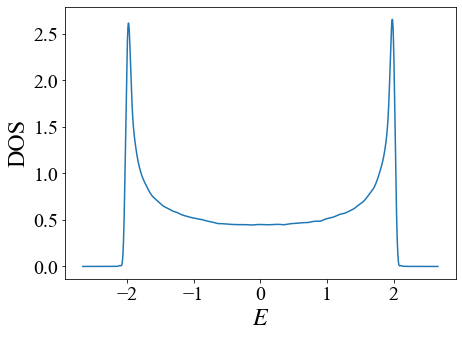

In [3]:
shape = 50000
H = tb.get_tight_binding_Hamiltonian(shape)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=2.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 3D

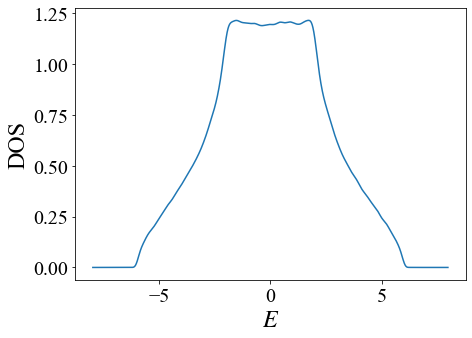

In [4]:
shape = (50,50,50)
H = tb.get_tight_binding_Hamiltonian(shape)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=6.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

maximum eigenvalue = 2.764, computation time = 5.903 [s]


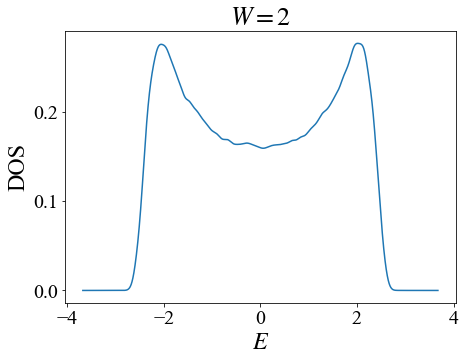

0.1595890516234451


In [4]:
from scipy.interpolate import interp1d

shape = 512*512
W = 2
V = np.random.uniform(-0.5*W, 0.5*W, shape)
H = tb.get_tight_binding_Hamiltonian(shape, bc='fixed')
H = tb.onsite_potential(H, V)

# 適切なエネルギースケールがわからないときは、H_scale に値を与えなければ勝手に計算してくれる。ただし、W が 0 または小さいときは計算がなかなか収束しないので H_scale を与えたほうが良い。
kpm = KPM(H, N_random=20, N_moments=200, N_division=4000, kernel='Jackson')
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
dos = kpm.get_DOS(energy)
dE = energy[1] - energy[0]
dos /= np.sum(dos*dE)

dos = interp1d(energy, dos)
plt.plot(energy, dos(energy))
plt.title(r'$W={:.1g}$'.format(W))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

print(dos(0))

maximum eigenvalue = 2.046, computation time = 21.86 [s]


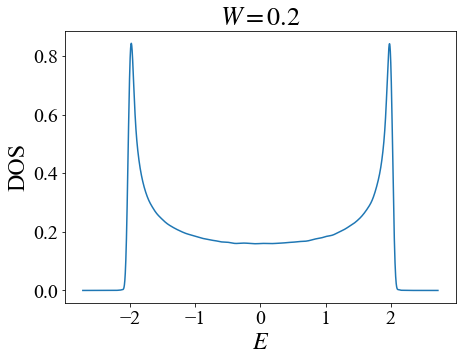

0.1601744864072373


In [5]:
shape = 512*512
W = 0.2
V = np.random.uniform(-0.5*W, 0.5*W, shape)
H = tb.get_tight_binding_Hamiltonian(shape, bc='fixed')
H = tb.onsite_potential(H, V)

# 適切なエネルギースケールがわからないときは、H_scale に値を与えなければ勝手に計算してくれる。ただし、W が 0 または小さいときは計算がなかなか収束しないので H_scale を与えたほうが良い。
kpm = KPM(H, N_random=20, N_moments=200, N_division=4000, kernel='Jackson')
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
dos = kpm.get_DOS(energy)
dE = energy[1] - energy[0]
dos /= np.sum(dos*dE)

dos = interp1d(energy, dos)
plt.plot(energy, dos(energy))
plt.title(r'$W={:.1g}$'.format(W))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

print(dos(0))

In [6]:
rho = 0.160
N = 2**18
eps = 0.02

rho*eps*2*N

1677.7216

20001


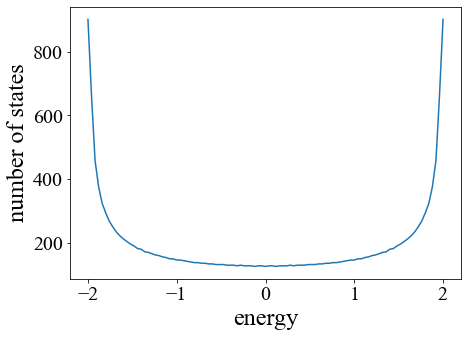

In [27]:
def calc_dos1D(Nx, N_dos, t = 1):
    # fortranと合わせるため、 +1 する。
    kx = np.linspace(-np.pi, np.pi, 2*Nx+1)
    print(len(kx))
    #ky = np.linspace(-np.pi, np.pi, 2*Ny+1)
    #KX, KY = np.meshgrid(kx, ky)
    energy = -2*t*np.cos(kx)
    
    E_max = np.max(energy)
    E_min = np.min(energy)
    dE = (E_max - E_min)/(N_dos)   # ここは +1 しない
    E_dos = np.linspace(E_min, E_max, N_dos+1)
    
    DOS = np.array([
        np.count_nonzero(np.logical_and(energy[1:] < e+dE/2, energy[1:] > e-dE/2))\
        for e in E_dos
    ])   # 同じ波数(pi と -pi)を重複して数えないようにする。

    return E_dos, DOS#/(2*Nx)

N = [10000]
for n in N:
    energy, dos = calc_dos1D(n, 100)
    plt.plot(energy, dos)
    plt.xlabel('energy')
    plt.ylabel('number of states')
    plt.show()

In [26]:
dE = energy[1] - energy[0]
np.sum(dE*dos)

800.0000000000007

In [19]:
print(dos(0))

0.16005653573840423


### 3D + disorder (W=10)

maximum eigenvalue = 8.215, computation time = 2.512 [s]


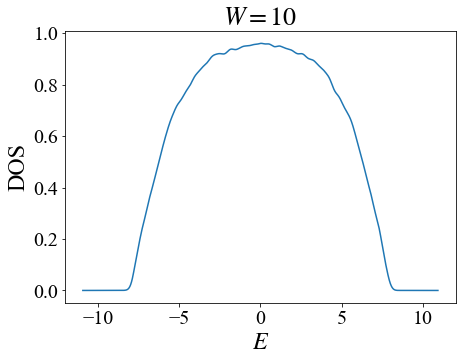

In [5]:
shape = (50,50,50)
W = 10.
V = np.random.uniform(-0.5*W, 0.5*W, shape)
H = tb.get_tight_binding_Hamiltonian(shape)
H = tb.onsite_potential(H, V)

# 適切なエネルギースケールがわからないときは、H_scale に値を与えなければ勝手に計算してくれる。ただし、W が 0 または小さいときは計算がなかなか収束しないので H_scale を与えたほうが良い。
kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson')
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$W={:.0f}$'.format(W))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

## Ando model

ハミルトニアン (2D)

$$
H = t\sum_{\bm{n}}\sum_{\xi=\pm x,\pm y} c^{\dag}_{\bm{n}+\bm{\mathrm{e}}_{\xi}}T_{\xi}c^{}_{\bm{n}} + \sum_{\bm{n}}W_{\bm{n}}c^{\dag}_{\bm{n}}\bm{1}c^{}_{\bm{n}}
$$

ここで、$T_{\xi}$ は

$$
T_{\pm x} = \left(
    \begin{array}{cc}
    t_1 & \pm t_2\\
    \mp t_2 & t_1
    \end{array}
\right),\ \ 
T_{\pm y} = \left(
    \begin{array}{cc}
    t_1 & \mp it_2\\
    \mp it_2 & t_1
    \end{array}
\right),\ \ \ 
t_1^2+t_2^2 = 1

### 2D, S=0

maximum of imaginaly part of DOS = 0


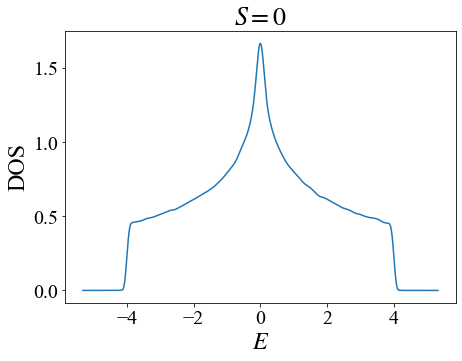

In [6]:
shape = (200,200)
t1 = 1.
t2 = 0.
H = tb.get_Ando_Hamiltonian(shape,t1,t2)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$S={:.1g}$'.format(t2))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 2D, S=1/2

maximum of imaginaly part of DOS = 2.94e-17


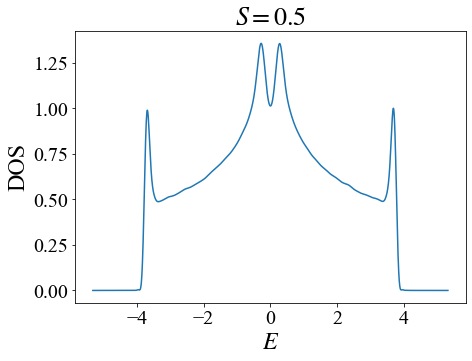

In [7]:
shape = (200,200)
t1 = np.sqrt(0.75)
t2 = 0.5
H = tb.get_Ando_Hamiltonian(shape,t1,t2)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$S={:.1g}$'.format(t2))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 2D, S=1/2, W=3

maximum eigenvalue = 4.478, computation time = 3.326 [s]
maximum of imaginaly part of DOS = 3.65e-17


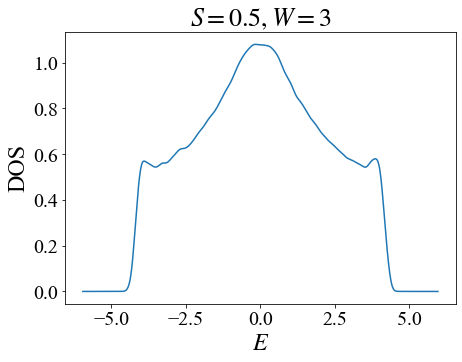

In [8]:
shape = (200,200)
t1 = np.sqrt(0.75)
t2 = 0.5
W = 3.
V = np.random.uniform(-0.5*W, 0.5*W, shape)
# オンサイトポテンシャルの定義の仕方注意。
V = np.array([V,V])
H = tb.get_Ando_Hamiltonian(shape,t1,t2)
H = tb.onsite_potential(H,V)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson')
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$S={:.1g}, W={:.0f}$'.format(t2,W))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

## Hofstadter model

ハミルトニアン (2D)

$$
H = t\sum_{\bm{n}} \left(c^{\dag}_{\bm{n}+\bm{\mathrm{e}}_{x}}c^{}_{\bm{n}} + e^{-2i\pi\phi x}c^{\dag}_{\bm{n}+\bm{\mathrm{e}}_{y}}c^{}_{\bm{n}}\right) + \mathrm{H.c.} + \sum_{\bm{n}}W_{\bm{n}}c^{\dag}_{\bm{n}}c^{}_{\bm{n}}
$$

z軸方向に磁束 $\phi$ の磁場がかかっている。

### 2D, phi=1/4

maximum of imaginaly part of DOS = 3.36e-17


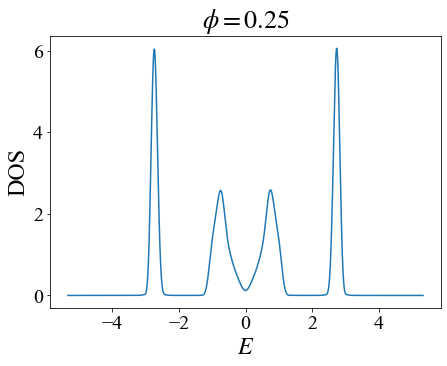

In [9]:
shape = (200,200)
phi = 1./4
H = tb.get_Hofstadter_Hamiltonian(shape, phi)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$\phi={:.3g}$'.format(phi))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 2D, phi=1/3

maximum of imaginaly part of DOS = 2.32e-17


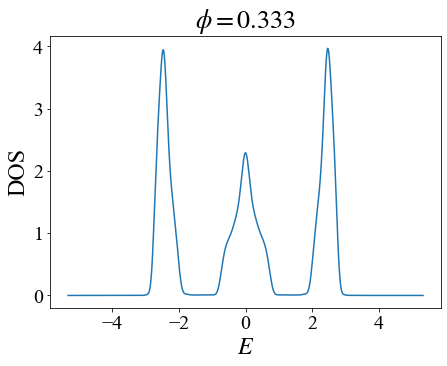

In [10]:
shape = (200,200)
phi = 1./3
H = tb.get_Hofstadter_Hamiltonian(shape, phi)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson', H_scale=4.)
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$\phi={:.3g}$'.format(phi))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

### 2D, phi=1/4, W=3

maximum eigenvalue = 3.918, computation time = 1.695 [s]
maximum of imaginaly part of DOS = 1.57e-17


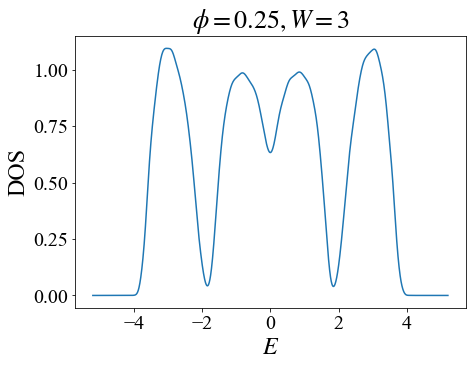

In [12]:
shape = (200,200)
phi = 1./4
W = 3.
V = np.random.uniform(-0.5*W, 0.5*W, shape)
H = tb.get_Hofstadter_Hamiltonian(shape, phi)
H = tb.onsite_potential(H,V)

kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson')
energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
plt.plot(energy, kpm.get_DOS(energy))
plt.title(r'$\phi={:.3g}, W={:.0f}$'.format(phi,W))
plt.xlabel(r'$E$')
plt.ylabel('DOS')
plt.show()

## LDOS

KPM ではサイト $i$ における局所状態密度 (LDOS) も計算できる。  
LDOS $\rho_i$ の幾何平均である、typical density of states $\rho_{\mathrm{typ}}$

$$
\rho_{\mathrm{typ}} = \exp\left(\left\langle\ln[\rho_i(E)]\right\rangle\right)
$$

は、乱れが大きくなると 0 に近づく。

### Tight-binding model, W=3,9,16

maximum eigenvalue = 6.206, computation time = 2.867 [s]


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


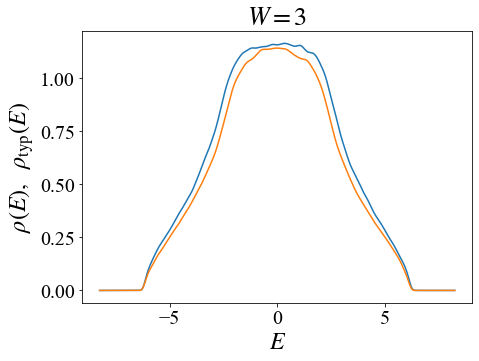

maximum eigenvalue = 7.883, computation time = 0.9401 [s]


100%|██████████| 1000/1000 [01:44<00:00,  9.60it/s]


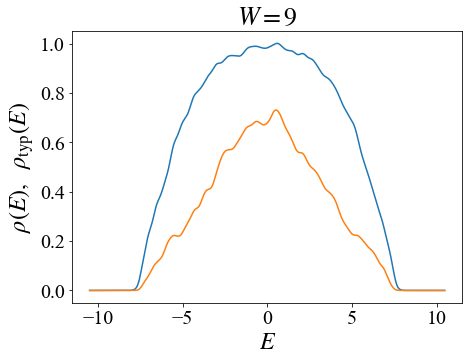

maximum eigenvalue = 10.79, computation time = 0.823 [s]


100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s]


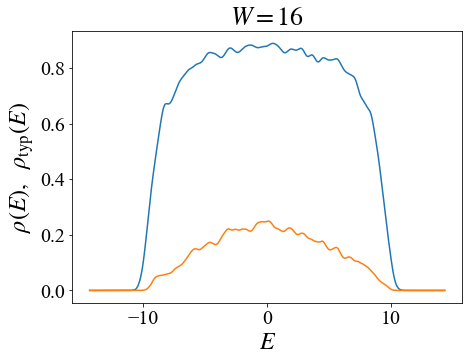

In [4]:
shape=(40,40,40)
H0 = tb.get_tight_binding_Hamiltonian(shape)
W_list = [3,9,16]
N_sample = 1000

for W in W_list:
    V = np.random.uniform(-0.5*W, 0.5*W, shape)
    H = tb.onsite_potential(H0,V)
    kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson')
    energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
    dos = kpm.get_DOS(energy)
    ldos = np.zeros_like(energy)
    for i in tqdm(range(N_sample)):
        ldos += np.log(kpm.get_LDOS(energy,i)+1e-8)
    ldos /= N_sample
    ldos = np.exp(ldos)
    plt.plot(energy, dos)
    plt.plot(energy, ldos)
    plt.title(r'$W={:.0f}$'.format(W))
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\rho(E),\ \ \rho_{\mathrm{typ}}(E)$')
    plt.show()

### Ando model, W=3,8

maximum eigenvalue = 4.476, computation time = 3.766 [s]
maximum of imaginaly part of DOS = 2.16e-17


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


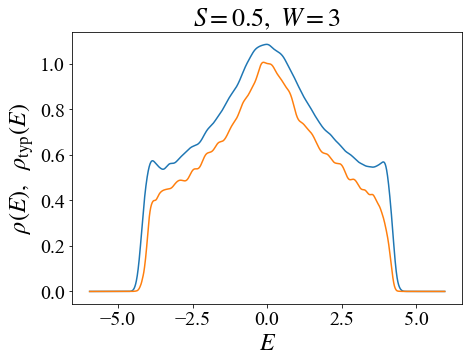

maximum eigenvalue = 6.378, computation time = 2.35 [s]
maximum of imaginaly part of DOS = 1.6e-17


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


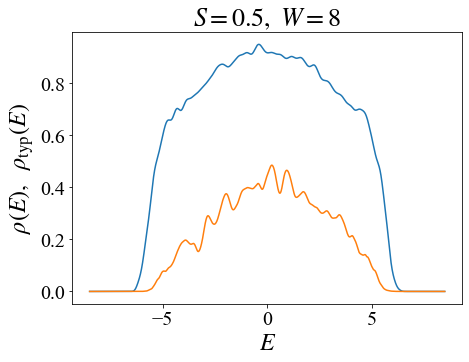

In [3]:
shape=(200,200)
t1 = np.sqrt(0.75)
t2 = 0.5
H0 = tb.get_Ando_Hamiltonian(shape,t1,t2)
W_list = [3,8]
N_sample = 500

for W in W_list:
    V = np.random.uniform(-0.5*W, 0.5*W, shape)
    V = np.array([V,V])
    H = tb.onsite_potential(H0,V)
    kpm = KPM(H, N_random=20, N_moments=200, N_division=2000, kernel='Jackson')
    energy = np.linspace(-kpm.H_scale*0.95,kpm.H_scale*0.95,kpm.N_division)
    dos = kpm.get_DOS(energy)
    ldos = np.zeros_like(energy)
    for i in tqdm(range(N_sample)):
        ldos += np.log(kpm.get_LDOS(energy,i)+1e-8)
    ldos /= N_sample
    ldos = np.exp(ldos)
    plt.plot(energy, dos)
    plt.plot(energy, ldos)
    plt.title(r'$S={:.1g},\ W={:.0f}$'.format(t2,W))
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\rho(E),\ \ \rho_{\mathrm{typ}}(E)$')
    plt.show()